# Simplified Pipeline

The following cells provide a simplified template of the steps used on part 1 of the BLU12 Learning Notebook. These steps are not the only way to get a RS up and running and we encourage you to tweak them as you see fit.

In [1]:
# Import the necessary dependencies

# Operating System
import os
import gc

# Numpy, Pandas and Scipy
import numpy as np
import pandas as pd
import json

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# LightFM
from lightfm import LightFM
from lightfm.data import Dataset as lfmDataset 

# Surprise
from surprise import SVD
from surprise import Dataset as sDataset
from surprise import Reader

# Model Evaluation
from evaluation import evaluate_solution

# RAM control
from ramcontrol import check_memory_limit, memory_circuit_breaker

In [2]:
# limit of total memory percentage that be used [0.,100.]
memory_limit_perc = 70.

## Understanding the data

- The dataset that you selected is appropriated for building a RS?
- Do you have data regarding the items or only about the users' preference?
- Do you have a test dataset or do you have to create it?

In [3]:
! head -5 data/data/beer_metadata.csv

beer_id,beer_name,brewer_id,beer_abv,beer_style
63836,John Harvards Simcoe IPA,8481,5.4,India Pale Ale &#40;IPA&#41;
71716,John Harvards Cristal Pilsner,8481,5,Bohemian Pilsener
64125,John Harvards Fancy Lawnmower Beer,8481,5.4,Klsch
31544,John Harvards Vanilla Black Velvet Stout,8481,-,Sweet Stout


In [4]:
! head -5 data/data/test_users.csv

user_name
wlajwl
BigBang
GhostFace
sbanach


In [5]:
! head -5 data/data/train_ratings.csv

beer_id,user_name,review_score,review_time
63836,hopdog,13/20,1157587200
63836,TomDecapolis,13/20,1157241600
71716,PhillyBeer2112,14/20,958694400
64125,TomDecapolis,8/20,1157587200


## Load the Data

In [3]:
train_ratings = pd.read_csv('data/data/train_ratings.csv')
train_ratings

/tmp/ipykernel_33518/122761860.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_ratings = pd.read_csv('data/data/train_ratings.csv')


,beer_id,user_name,review_score,review_time
0,63836,hopdog,13/20,1157587200
1,63836,TomDecapolis,13/20,1157241600
2,71716,PhillyBeer2112,14/20,958694400
3,64125,TomDecapolis,8/20,1157587200
4,64125,hopdog,8/20,1157587200
...,...,...,...,...
2838369,98518,Snojerk321,11/20,1233964800
2838370,98518,troopie,13/20,1233446400
2838371,98518,Reid,14/20,1233360000
2838372,98518,boFNjackson,14/20,1233100800


In [4]:
train_ratings.review_score.unique()

array(['13/20', '14/20', '8/20', '16/20', '12/20', '17/20', '11/20',
       '9/20', '15/20', '10/20', '20/20', '6/20', '5/20', '7/20', '18/20',
       '19/20', '4/20', '2/20', '3/20', '1/20'], dtype=object)

In [5]:
train_ratings.review_score = train_ratings.review_score.str.split('/', expand=True)[0]
train_ratings.review_score = train_ratings.review_score.apply(int)
train_ratings.review_time = pd.to_datetime(train_ratings.review_time, unit='s')
train_ratings

,beer_id,user_name,review_score,review_time
0,63836,hopdog,13,2006-09-07
1,63836,TomDecapolis,13,2006-09-03
2,71716,PhillyBeer2112,14,2000-05-19
3,64125,TomDecapolis,8,2006-09-07
4,64125,hopdog,8,2006-09-07
...,...,...,...,...
2838369,98518,Snojerk321,11,2009-02-07
2838370,98518,troopie,13,2009-02-01
2838371,98518,Reid,14,2009-01-31
2838372,98518,boFNjackson,14,2009-01-28


In [6]:
train_ratings.beer_id = pd.to_numeric(train_ratings.beer_id, errors='coerce')
train_ratings = train_ratings.dropna()
train_ratings.beer_id = train_ratings.beer_id.apply(int)
train_ratings.head()


/tmp/ipykernel_33518/1213118883.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ratings.beer_id = train_ratings.beer_id.apply(int)


,beer_id,user_name,review_score,review_time
0,63836,hopdog,13,2006-09-07
1,63836,TomDecapolis,13,2006-09-03
2,71716,PhillyBeer2112,14,2000-05-19
3,64125,TomDecapolis,8,2006-09-07
4,64125,hopdog,8,2006-09-07


In [7]:
train_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2838334 entries, 0 to 2838373
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   beer_id       int64         
 1   user_name     object        
 2   review_score  int64         
 3   review_time   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 108.3+ MB


<AxesSubplot:>

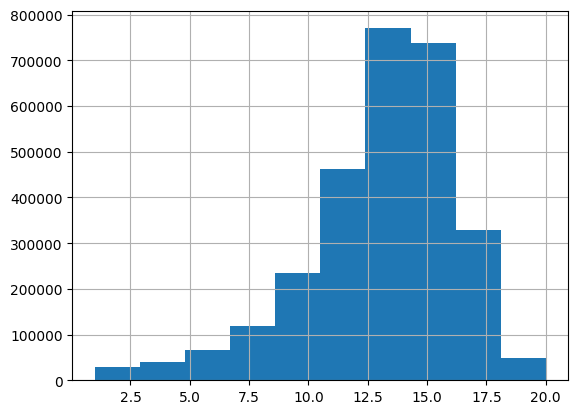

In [12]:
train_ratings.review_score.hist()

In [105]:
train_ratings.review_score.value_counts().sort_index()

1      15566
2      14250
3      17683
4      21700
5      31021
6      35984
7      47153
8      72652
9      81465
10    154083
11    170251
12    291325
13    348945
14    421223
15    411208
16    327822
17    215218
18    112962
19     34473
20     13350
Name: review_score, dtype: int64

In [106]:
train_ratings.isnull().sum()

beer_id         0
user_name       0
review_score    0
review_time     0
dtype: int64

In [107]:
print('How many unique users:', train_ratings.user_name.nunique())

How many unique users: 29027


In [8]:
beers = pd.read_csv('data/data/beer_metadata.csv')
beers

,beer_id,beer_name,brewer_id,beer_abv,beer_style
0,63836,John Harvards Simcoe IPA,8481,5.4,India Pale Ale &#40;IPA&#41;
1,71716,John Harvards Cristal Pilsner,8481,5,Bohemian Pilsener
2,64125,John Harvards Fancy Lawnmower Beer,8481,5.4,Klsch
3,31544,John Harvards Vanilla Black Velvet Stout,8481,-,Sweet Stout
4,71714,John Harvards American Brown Ale,8481,-,Brown Ale
...,...,...,...,...,...
112045,958,Pyramid Best Brown,154,5.1,Brown Ale
112046,959,Pyramid Espresso Stout,154,-,Sweet Stout
112047,98518,Pyramid Rollick Amber Lager,154,6,Amber Ale
112048,98914,Pyramid Snow Cap&#40;&#8217;n & Tennille&#41;,154,7,English Strong Ale


In [14]:
beers.beer_id.nunique()

110254

In [15]:
beers.beer_id.duplicated().sum()

1796

In [16]:
beers[beers.beer_id.duplicated(keep=False)].sort_values(by='beer_id')

,beer_id,beer_name,brewer_id,beer_abv,beer_style
46914,100023,21st Amendment Monks Blood,1391,8.3,Belgian Strong Ale
37198,100023,21st Amendment Monks Blood,1306,8.3,Belgian Strong Ale
84383,10008,Gulpener Gallius,674,8,Strong Pale Lager/Imperial Pils
66310,10008,Gulpener Gallius,114,8,Strong Pale Lager/Imperial Pils
6189,10019,Tetleys Cask Bitter,4869,3.7,Bitter
...,...,...,...,...,...
88815,99485,Vices et Versa Hefeweizen,10244,-,German Hefeweizen
71638,99704,Briar Creek Towhead Ale,886,-,Golden Ale/Blond Ale
1802,99704,Briar Creek Towhead Ale,10256,-,Golden Ale/Blond Ale
72893,99791,Blowing Rock Bock Lager,11031,-,Heller Bock


In [9]:
test_users = pd.read_csv('data/data/test_users.csv')
test_users

,user_name
0,wlajwl
1,BigBang
2,GhostFace
3,sbanach
4,IrishBoy
...,...
1803,snapple2
1804,lenomatic1
1805,TonyDiUlio
1806,gambrilivinus


In [18]:
test_users.user_name.nunique()

1808

## Process and clean data
- Check if data needs to be processed and cleaned.
- Process and clean data if necessary.

In [10]:
ratings = train_ratings.copy().drop(columns='review_time')
ratings.head()

,beer_id,user_name,review_score
0,63836,hopdog,13
1,63836,TomDecapolis,13
2,71716,PhillyBeer2112,14
3,64125,TomDecapolis,8
4,64125,hopdog,8


In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2838334 entries, 0 to 2838373
Data columns (total 3 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   beer_id       int64 
 1   user_name     object
 2   review_score  int64 
dtypes: int64(2), object(1)
memory usage: 86.6+ MB


## Identify and separate the Users
- Which users are present in the training data?
- Make sure that you identify which test users are present in the training data and which are not.
- Can you use personalized methologies for all users?

#### Training set

In [12]:
data_train, data_val = train_test_split(ratings, test_size=0.4, random_state=123)

In [22]:
print(f"We have {len(data_train):,} ratings in total in the training set.")

We have 1,703,000 ratings in total in the training set.


In [23]:
print(f" We have {data_train['beer_id'].unique().size:,} beers rated.")

 We have 96,571 beers rated.


In [24]:
print(f" We have {data_train['user_name'].unique().size:,} users that rated at least one beer.")

 We have 24,408 users that rated at least one beer.


#### Validation set

In [25]:
print(f"We have {len(data_val):,} ratings in total in the validation set.")
print(f" We have {data_val['beer_id'].unique().size:,} beers rated.")
print(f" We have {data_val['user_name'].unique().size:,} users that rated at least one beer.")

We have 1,135,334 ratings in total in the validation set.
 We have 85,823 beers rated.
 We have 21,278 users that rated at least one beer.


#### Select reviews from users with at least 50 positive ratings.

In [13]:
def select_frequent_reviewers(df: pd.DataFrame, min_nr_reviews: int = 50, min_rating: int = 13):
    """
    Select reviews from users with at least min_nr_reviews reviews with rating larger than min_rating.
    """
    
    # Select only positive reviews
    df_positive = df.copy().loc[df["review_score"] >= min_rating]

    # Select users with more than min_nr_reviews positive reviews
    user_review_count = df_positive.groupby(by=["user_name"])["beer_id"].count()
    test_users_list = list(user_review_count[user_review_count > min_nr_reviews].index)

    # Select ratings from users specified above
    df_restrict = df_positive.copy().loc[df_positive["user_name"].isin(test_users_list)]
    
    return df_restrict

data_val_final = select_frequent_reviewers(data_val)
data_val_final

,beer_id,user_name,review_score
747559,2208,pilsnerrogge,19
1410125,6867,mar,13
406448,37134,Sammy,14
2141118,142778,HonkeyBra,15
247270,74533,DTM,15
...,...,...,...
775194,10704,onlyrocknroll,13
538700,61447,Eyedrinkale,18
2674927,84453,downender,13
391263,4664,maniac,13


In [14]:
users_val = data_val_final["user_name"].unique().tolist()
print(f"We are validating recommendations with {len(users_val)} users.")

We are validating recommendations with 2505 users.


In [15]:
# nr of recommendations per user
k_top = 50

def top_items_per_user(df: pd.DataFrame, user_col: str, rating_col:str, k_top: int = 50):

    df_users_kbest = df.copy().groupby(by=[user_col])[rating_col].nlargest(k_top).reset_index()
    df_users_kbest['rank'] = df_users_kbest.groupby(by=[user_col])[rating_col].rank(method="first")
    #df_users_kbest['rank'] = df_users_kbest['rank'].astype(int) - 1
    df_recommendations = df_users_kbest.pivot(index=user_col, columns="rank", values="level_1")
    df_recommendations = df_recommendations.reset_index(drop=False)
    df_recommendations.columns = np.arange(len(df_recommendations.columns))
    return df_recommendations

val_recommendations = top_items_per_user(data_val_final, "user_name", "review_score", k_top=k_top)
val_recommendations

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,00cobraR,2225611,104805,1757047,635219,5043,2144300,1777883,2088356,1349854,...,1765323,1751180,2258720,1556241,1109037,301395,1749163,614481,102841,455475
1,0o9i,186490,2152848,1989445,1159004,740474,209063,2631380,1714842,2156267,...,458777,68978,2051262,71066,456853,2084002,1938696,2819151,253110,614614
2,1010,877036,883894,2409194,890909,2561641,712978,2794313,2509938,2733634,...,2562125,250691,2767933,2408228,1748043,2562077,1740863,1117030,865977,1114053
3,11026,1013409,1865812,1349919,844162,2083088,845342,931927,2682684,1556733,...,296840,2686994,1826697,1107840,82599,2238148,1610545,1826922,822050,2137605
4,12many,634960,12041,252679,2443775,633160,964744,2139098,2079830,1603365,...,2818668,2815908,302284,1762249,1949362,2134521,2146949,2559979,2134316,2288793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2500,zizzybalubba,2466595,2778482,2074818,2066627,2360710,477564,1868934,2243278,2645878,...,2047135,464973,2508113,971672,582169,675235,301844,1115571,822506,466798
2501,zombywoof,561085,1148207,1834274,2435684,2293980,2299296,2472241,873909,1052320,...,480365,504520,1914613,1632985,720312,1266133,2443755,352101,885245,1778968
2502,ztrvz,2406598,1583744,993101,785799,815988,2785543,2564348,1140203,2438762,...,1706962,1137275,2500070,818919,301594,1592615,2226029,2626036,1363515,921519
2503,zug4abby,2685453,2530894,1821316,65827,2600771,2453438,454420,736432,554024,...,2535592,464646,342719,455947,1368482,456911,755252,466079,60479,464584


## Create the Ratings Matrix

In [ ]:
# YOUR CODE HERE

## Non-Personalized Recommendations
- Create non-personalized recommendations as a baseline.
- Apply the recommendations to the test users.
- Store results in the required format for submission.
- Submit baseline recommendations.

In [16]:
def non_pers_reco_order(data: pd.DataFrame,
                        item_col: str,
                        rating_col:str,
                        k_top: int = 50,
                        aggregation: list() = ["mean", "count"]):
    """
    Create an ordered list of non-personalized recommendations, from best rated to worst rated.
    """
    non_pers_ratings = data.groupby(by=[item_col])[[rating_col]].agg(aggregation)
    non_pers_ratings.columns = non_pers_ratings.columns.get_level_values(1)
    
    #The resulting column names might be different than the specified with the aggregation parameter.
    try:
        non_pers_ratings = non_pers_ratings.sort_values(by=aggregation, ascending=False).head(k_top)
    except KeyError as e:
        print(e)
        print("Check if aggregation argument results in valid column names.")
        print(f"aggregation = {aggregation}\nrating columns = {non_pers_ratings.columns}")
        raise e
        
    non_pers_reco_list = non_pers_ratings.index.to_list()
    return non_pers_reco_list


non_pers_recommendations = non_pers_reco_order(data_train, "beer_id", "review_score", k_top=k_top)
print(non_pers_recommendations)

[8485, 1831, 6892, 8212, 10336, 13658, 18478, 22907, 26707, 29205, 29862, 41065, 42760, 51994, 52084, 54342, 54531, 57989, 58697, 58775, 59521, 67598, 67957, 68919, 69839, 76679, 78989, 79482, 86102, 86570, 88202, 90311, 90670, 91620, 110567, 111712, 111815, 114456, 116255, 117558, 117560, 131728, 141976, 144910, 147738, 151723, 155529, 157370, 157699, 159696]


In [17]:
def non_pers_reco_output(user_id_list:list, non_pers_reco_list:list):
    """
    Creates a non-personalized recommendation dataframe for specified users.
    """
    nr_test_users = len(user_id_list)
    user_id_df = pd.DataFrame(user_id_list, columns = ["user_id"])
    non_pers_reco_repeated =  pd.DataFrame(pd.DataFrame(non_pers_reco_list).T.values.repeat(nr_test_users, axis=0))
    non_pers_reco_output = pd.concat([user_id_df, non_pers_reco_repeated], axis=1)
    
    # Reset columns numbering. Useful later.
    #non_pers_reco_output.columns = np.arange(len(non_pers_reco_output.columns))
    
    return non_pers_reco_output

## Evaluate results
- Calculate the evaluation metric on the validation users.
- Compare it later with the personalized recommendations

In [ ]:
# YOUR CODE HERE

## Personalized Recommendations: Collaborative Filtering
- Compute the user similarities matrix.
- Predict ratings.
- Select the best recommendations.
- Submit recommendations.

In [19]:
data_train = data_train[['user_name', 'beer_id', 'review_score']]
data_train

,user_name,beer_id,review_score
929489,pivnizub,41642,10
62794,brentfeesh,7859,16
131954,JorisPPattyn,24532,14
661254,GeniusGirl,8426,14
2775302,sersdf,97568,15
...,...,...,...
1954943,tennisjoel,1190,15
1241081,dominion,649,18
28030,jhumphries69,72686,12
277884,tnkw01,80837,10


In [20]:
data_train.user_name.nunique()

24408

In [21]:
data_train.beer_id.nunique()

96571

In [22]:
# Notice the alias lfmDataset() instead of the standard Dataset()
# Used to distiguish between lightFM Dataset() and another Dataset() that we use later.
lfmdataset = lfmDataset()
lfmdataset.fit(data_train['user_name'], data_train["beer_id"])

In [23]:
num_users, num_items = lfmdataset.interactions_shape()
print('Num users: {:,}, num_items {:,}.'.format(num_users, num_items))

Num users: 24,408, num_items 96,571.


In [24]:
user_id_map, user_feature_map, item_id_map, item_feature_map = lfmdataset.mapping()

In [25]:
item_id_map_reverse = {v: k for k, v in item_id_map.items()}

In [26]:
(interactions, weights) = lfmdataset.build_interactions(data_train.values)

print(repr(interactions))

<24408x96571 sparse matrix of type '<class 'numpy.int32'>'
	with 1703000 stored elements in COOrdinate format>


In [27]:
lfmodel = LightFM(loss='warp')

In [28]:
lfmodel.fit(interactions)

In [169]:
k_top = 50

# external user ID to predict
user_ext_id_example = 'pivnizub'

# internal user ID to predict
user_id_example = user_id_map[user_ext_id_example]

#item internal ids
item_id_int_list = list(item_id_map.values())

# Calculates the score (rating) of each item
scores = lfmodel.predict(user_id_example, item_id_int_list)

# Sort the items from highest to lowest score
top_items_ids = np.argsort(-scores)
top_items_ids = [item_id_map_reverse[ids] for ids in top_items_ids]

# Individual row. Two steps are necessary for the first column to call "user_id"
user_id_df = pd.DataFrame([user_ext_id_example], columns=["user_name"])
top_items_ids = pd.DataFrame([top_items_ids[:k_top]])
user_reco_df = pd.concat([user_id_df,top_items_ids], axis=1)
user_reco_df

,user_name,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,pivnizub,13324,36339,46898,38,70332,47364,1014,79917,16939,...,15721,24569,45100,39881,5760,5571,83911,5849,4003,11056


In [170]:
# some users
user_id_ext_list = ['pivnizub', 'brentfeesh', '999999999'] #last ID is made up

# Split old users (user_id_int_list) from new users (user_id_ext_excluded)
user_id_int_list = []
user_id_ext_excluded = []

for user_id_ext in user_id_ext_list:
    try:
        # user internal ID with mapping
        user_id_int_list.append(user_id_map[user_id_ext])
    except:
        # user without mapping
        user_id_ext_excluded.append(user_id_ext)

print(f"The INTERNAL ID of users with mapping are: {user_id_int_list}")
print(f"The EXTERNAL ID of users without mapping are: {user_id_ext_excluded}")

The INTERNAL ID of users with mapping are: [0, 1]
The EXTERNAL ID of users without mapping are: ['999999999']


In [171]:
# list of item external ids
item_id_ext_list = list(item_id_map.values())

In [172]:
#Dataframe with model recommendations
model_reco_df = pd.DataFrame()

##Collaborative recommendations
for user_id in user_id_int_list:
    scores = lfmodel.predict(user_id, item_id_ext_list)
    top_items_ids = np.argsort(-scores)
    top_items_ids = [item_id_map_reverse[ids] for ids in top_items_ids]

    user_reco_df = pd.DataFrame([[user_id] + top_items_ids[:k_top]])
    
    #Appending rows
    model_reco_df = pd.concat([model_reco_df, user_reco_df])
model_reco_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0,13324,36339,46898,38,70332,47364,1014,79917,16939,...,15721,24569,45100,39881,5760,5571,83911,5849,4003,11056
0,1,3214,10569,1502,1267,11243,589,680,371,46,...,5596,7859,52,87,591,171,35488,3211,7177,473


In [173]:
## Non-personalized recommendations
non_pers_reco_df = non_pers_reco_output(user_id_ext_excluded, non_pers_recommendations)
non_pers_reco_df

,user_id,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,999999999,8485,1831,6892,8212,10336,13658,18478,22907,26707,...,117560,131728,141976,144910,147738,151723,155529,157370,157699,159696


In [29]:
def lightFM_recommendations(dataset,
                            model,
                            user_id_ext_list,
                            non_pers_reco_list,
                            k_top: int = 50,
                            item_features = None):   
    """
    Create output dataframe with recommendations based on dataset, model and list of users.
    
    This function predicts recommendations for users specified in user_id_ext_list that are present in the lightFM dataset.
    New users are recommended the items in the non-personalized list non_per_reco_list.
    
    Parameters:
    -----------
    dataset: lightFM dataset
    
    model: lightFM trained model
    
    user_id_ext_list: list of user external IDs to predict
    
    non_pers_reco: list of non-personalized recommendations ordered from best to worst rated
    
    k_top: number of recommendations to create per user
    
    item_features: lightFM item features
    
    Returns:
    --------
    final_reco_df: dataframe with users' recommendations
    The first column has the users' ID and the remaining columns have the recommendations
    """
    
    assert len(user_id_ext_list) > 0, "User ID list length must be larger than 0."
    
    # Dataset mappings
    user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()
    
    # reverse mapping
    item_id_map_reverse = {v: k for k, v in item_id_map.items()}
    #print(item_id_map_reverse)
    user_id_map_reverse = {v: k for k, v in user_id_map.items()}
    #print(user_id_map_reverse)
    
    
    # item internal ids
    item_id_int_list = list(item_id_map.values())
    
    # Split old users (user_id_int_list) from new users (user_id_ext_excluded)
    # Old users are defined in the ratings vectorial space.
    # New users are not defined in the ratings vectorial space.
    # New users receive non-personalized recommendations.
    user_id_int_list = []
    user_id_ext_excluded = []
    
    for user_id_ext in user_id_ext_list:
        try:
            user_id_int_list.append(user_id_map[user_id_ext])
        except:
            user_id_ext_excluded.append(user_id_ext)
    
    # Dataframe to store model recommendations
    model_reco_df = pd.DataFrame()
    
    # Model recommendations
    for user_id in user_id_int_list:
        scores = model.predict(user_id, item_id_int_list, item_features)
        top_items_ids = np.argsort(-scores)
        top_items_ids = [item_id_map_reverse[ids] for ids in top_items_ids]
         
        # Individual row. Two steps are necessary for the first row to call "user_id"
        #print(user_id_map_reverse[user_id], type(user_id_map_reverse[user_id]))
        user_id_df = pd.DataFrame([user_id_map_reverse[user_id]], columns=["user_name"], dtype = str)
        top_items_ids = pd.DataFrame([top_items_ids[:k_top]])
        user_reco_df = pd.concat([user_id_df, top_items_ids], axis=1)
        
        # Concatenating rows
        model_reco_df = pd.concat([model_reco_df, user_reco_df])
        
        # Stop execution if memory is almost full
        memory_circuit_breaker(memory_limit_perc)
        
        
    # Non-personalized recommendations
    non_pers_reco_df = non_pers_reco_output(user_id_ext_excluded, non_pers_reco_list)
    
    # Concatenating all recommendations
    if model_reco_df.shape[0] == 0:
        final_reco_df = non_pers_reco_df
    elif non_pers_reco_df.shape[0] == 0:
        final_reco_df = model_reco_df
    else:
        final_reco_df = pd.concat([model_reco_df, non_pers_reco_df])
    
    return final_reco_df

In [30]:
lightFM_recommendations(lfmdataset,
                        lfmodel,
                        ['pivnizub', 'brentfeesh', 'JorisPPattyn', 'GeniusGirl'],
                        non_pers_recommendations,
                        k_top=k_top)

,user_name,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,pivnizub,46898,1014,6177,16730,42815,11942,6003,1261,2472,...,1157,73361,24532,4822,52716,4003,5419,7843,11211,44
0,brentfeesh,680,589,158,835,4315,46,14709,1267,10569,...,1090,1189,8837,2331,2530,132,25082,3076,1190,35488
0,JorisPPattyn,139,365,1316,1088,717,53,14709,10569,132,...,5107,2224,1762,48,4934,1156,288,37,1189,167
0,GeniusGirl,158,680,589,1267,835,14709,87,10569,365,...,45950,3022,1477,303,85,7293,424,3214,4934,421


In [31]:
collab_reco_val = lightFM_recommendations(lfmdataset, lfmodel, users_val, non_pers_recommendations, k_top=k_top)

In [32]:
collab_reco_val.head()

,user_name,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,pilsnerrogge,139,365,10569,14709,53,717,1088,1316,1926,...,48,37,709,94,167,9183,630,1763,618,1156
0,mar,589,680,1087,531,4315,46,835,371,14709,...,619,8909,2331,424,53,1190,717,35488,39508,1189
0,Sammy,589,835,46,1087,87,4315,680,14709,158,...,10514,51,2224,45950,37652,421,133,3214,132,39654
0,HonkeyBra,680,589,531,4315,158,46,10569,14709,835,...,35488,619,25082,1090,909,131958,742,32751,13667,39654
0,DTM,589,46,10569,4315,14709,835,680,158,87,...,8048,133,3022,132,473,303,2331,2530,619,742


In [33]:
output_col_reco = pd.DataFrame(collab_reco_val['user_name'])
output_col_reco.head()

,user_name
0,pilsnerrogge
0,mar
0,Sammy
0,HonkeyBra
0,DTM


In [34]:
output_col_reco = output_col_reco.assign(reco=[x.tolist() for x in collab_reco_val.set_index("user_name").values])
output_col_reco.head()

,user_name,reco
0,pilsnerrogge,"[139, 365, 10569, 14709, 53, 717, 1088, 1316, ..."
0,mar,"[589, 680, 1087, 531, 4315, 46, 835, 371, 1470..."
0,Sammy,"[589, 835, 46, 1087, 87, 4315, 680, 14709, 158..."
0,HonkeyBra,"[680, 589, 531, 4315, 158, 46, 10569, 14709, 8..."
0,DTM,"[589, 46, 10569, 4315, 14709, 835, 680, 158, 8..."


In [35]:
type(output_col_reco.set_index('user_name').to_dict()["reco"])

dict

In [36]:
def export_json(file_name, df ):
    dict_ = df.set_index('user_name').to_dict()["reco"]

    with open(file_name, "w") as outfile:
        json.dump(dict_, outfile)

In [182]:
export_json('output_collab_reco.json', output_col_reco)

In [150]:
def save_recommendations(df: pd.DataFrame, file_name: str):
    """
    Save recommendation dataframe as .csv.
    """
    
    file_path = os.path.join("data", f"{file_name}.csv")
    df.to_csv(file_path, index=False, header=False)
    print(f"Recommendations were saved on file {file_name}.csv.")

In [183]:
save_recommendations(collab_reco_val, 'collaborative_recommendations_VAL')

Recommendations were saved on file collaborative_recommendations_VAL.csv.


In [184]:
save_recommendations(val_recommendations, 'validation_recommendations')

Recommendations were saved on file validation_recommendations.csv.


In [185]:
evaluate_solution('collaborative_recommendations_VAL', 'validation_recommendations')

6.862937833295255e-07

#### For submission

In [192]:
test_users_list = test_users['user_name'].tolist()

In [193]:
submission_lightFM_1 = lightFM_recommendations(lfmdataset, 
                                               lfmodel, 
                                               test_users_list, 
                                               non_pers_recommendations, 
                                               k_top=k_top)

In [194]:
submission_lightFM_1.head()

,user_name,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,user_id
0,wlajwl,707,46,10569,365,51,158,3214,1502,680,...,1189,421,836,13667,2224,591,7177,1608,37,NaN
0,BigBang,680,10569,46,365,1267,589,3214,835,158,...,367,2224,1189,717,884,7293,139,3209,37,NaN
0,GhostFace,10569,3214,1267,680,589,1502,46,365,422,...,37,87,399,32751,836,139,37652,421,1921,NaN
0,sbanach,1267,3214,10569,1502,680,365,11243,1315,589,...,22904,87,139,707,4456,171,5596,421,3076,NaN
0,IrishBoy,707,46,3214,10569,680,1502,589,1266,422,...,742,1189,7178,1090,14709,41297,7293,1608,836,NaN


### with features

In [195]:
metadata_transformed = beers.copy()
metadata_transformed["beer_id"] = pd.to_numeric(metadata_transformed['beer_id'], errors='coerce')
metadata_transformed.dropna(how="any", inplace=True)
metadata_transformed["beer_id"] = metadata_transformed['beer_id'].astype("int")
metadata_transformed = metadata_transformed.drop(columns=["brewer_id"])
metadata_transformed = metadata_transformed.drop_duplicates()
metadata_transformed['beer_abv'] = pd.to_numeric(metadata_transformed['beer_abv'], errors='coerce')
metadata_transformed

,beer_id,beer_name,beer_abv,beer_style
0,63836,John Harvards Simcoe IPA,5.4,India Pale Ale &#40;IPA&#41;
1,71716,John Harvards Cristal Pilsner,5.0,Bohemian Pilsener
2,64125,John Harvards Fancy Lawnmower Beer,5.4,Klsch
3,31544,John Harvards Vanilla Black Velvet Stout,NaN,Sweet Stout
4,71714,John Harvards American Brown Ale,NaN,Brown Ale
...,...,...,...,...
112044,25876,Pyramid Underground Porter,5.5,Porter
112045,958,Pyramid Best Brown,5.1,Brown Ale
112046,959,Pyramid Espresso Stout,NaN,Sweet Stout
112047,98518,Pyramid Rollick Amber Lager,6.0,Amber Ale


In [196]:
beer_features = pd.get_dummies(metadata_transformed["beer_style"])
beer_features["beer_id"] = metadata_transformed["beer_id"]
beer_features["beer_abv"] = metadata_transformed.groupby('beer_style')[["beer_abv"]].transform(lambda group: group.fillna(group.mean()))
min_max_scaler = StandardScaler()
beer_features["beer_abv"] = min_max_scaler.fit_transform(beer_features[["beer_abv"]])
beer_features.set_index("beer_id", inplace=True)
beer_features

,Abbey Dubbel,Abbey Tripel,Abt/Quadrupel,Altbier,Amber Ale,American Dark Lager,American Pale Ale,American Strong Ale,Baltic Porter,Barley Wine,...,Spice/Herb/Vegetable,Stout,Strong Pale Lager/Imperial Pils,Sweet Stout,Traditional Ale,Vienna,Weizen Bock,Wheat Ale,Zwickel/Keller/Landbier,beer_abv
beer_id,,,,,,,,,,,,,,,,,,,,,
63836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.249642
71716,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.451629
64125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.249642
31544,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,-0.050877
71714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.210633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.199146
958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.401132
959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,-0.050877


In [197]:
beer_generator = beer_features.itertuples(index=True, name=None)
beer_dataset = lfmDataset()
beer_dataset.fit(data_train['user_name'], data_train["beer_id"], item_features=beer_generator)

In [205]:
item_features = beer_dataset.build_item_features(beer_generator)
(interactions, weights) = beer_dataset.build_interactions((row for row in data_train.values))

In [206]:
content_model = LightFM(loss='warp')
content_model.fit(interactions, item_features=item_features)

In [208]:
content_reco_val = lightFM_recommendations(beer_dataset,
                                           content_model,
                                           users_val,
                                           non_pers_recommendations,
                                           k_top=k_top,
                                           item_features = item_features)
save_recommendations(content_reco_val, "content_recommendations_VAL")

Recommendations were saved on file content_recommendations_VAL.csv.


In [209]:
evaluate_solution('content_recommendations_VAL', 'validation_recommendations')

3.3945714014148574e-07

## Evaluate results (Again)
- Calculate the evaluation metric on the validation users.

In [ ]:
# YOUR CODE HERE

## Content-based Recommendations

- Compute the item similarities matrix.
- Predict ratings.
- Select the best recommendations.
- Submit recommendations.

In [ ]:
# YOUR CODE HERE

## Evaluate results (Yet again)
- Calculate the evaluation metric on the validation users.

In [ ]:
# YOUR CODE HERE

## Potential improvements

At this point you can try to improve your prediction using several approaches:
- Aggregation of ratings from different sources. 
- Mixing Collaborative Filtering and Content-based Recommendations.
- Matrix Factorization.
- Could you use a classification or regression models to predict users' preference? 🤔

In [ ]:
# YOUR CODE HERE